## Setup

Choose the target board. For the time being, you can use `minized`, `pynqz1`, `pynqz2`, `cmoda735t`. You may need to install the proper board files for the chosen board.

In [1]:
## ZCU106
#board_name='zcu106'
#fpga_part='xczu7ev-ffvc1156-2-e'
 
## Ultra96
#board_name='ultra96'
#fpga_part='xczu3eg-sbva484-1-e'

## Pynq-Z1
board_name='pynqz1'
fpga_part='xc7z020clg400-1'

## Pynq-Z2
#board_name='pynqz2'
#fpga_part='xc7z020clg400-1'

## MiniZed
#board_name='minized'
#fpga_part='xc7z007sclg225-1'

##Cmod A7-35t
#board_name='cmoda735t'
#fpga_part='xc7a35tcpg236-1'

## Arty A7-100t
#board_name='artya7100t'
#fpga_part='xc7a100t-csg324-1'

## Arty A7-35t
#board_name='artya735t'
#fpga_part='xc7a35ticsg324-1L'

Add the project name. The notebook will create sub-directories for the Vivado projects with different models and configurations.

In [2]:
acc_name='anomaly_detector'

Let's import the libraries, call the magic functions, and setup the environment variables.

In [3]:
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects

import numpy as np

import hls4ml

from callbacks import all_callbacks
import plotting

import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['PATH'] = '/tools/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


## Load the dataset

This is a lot like the previous notebooks, so we will go through quickly.

First, we fetch the dataset from file, do the normalization and make a train and test split.

We save the test dataset to files so that we can use them later.

In [4]:
#load processed test data
from sklearn.utils import shuffle
X = np.load('./test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0.npy', allow_pickle=True)
y = np.load('./test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0_ground_truths.npy', allow_pickle=True)
y_keras = []
#use a quarter of the test_set to save time
for i in range(len(X)):
    quarter = int(len(X[i])/4)
    assert len(X) == len(y)
    #X[i], y[i] = shuffle(X[i], y[i])
    X[i], y[i] = X[i][0:quarter],  y[i][0:quarter]

## Train or Load Model

In [5]:
import keras_model
train = False
#not os.path.exists('model/KERAS_check_best_model.h5')
if train:
    model.compile(loss="mean_squared_error", optimizer="adam")
        
    print("Shape of training data element is: {}".format(train_data[0].shape))
    history = model.fit(train_data,
                        train_data,
                        epochs=100,
                        batch_size=512,
                        shuffle=true,
                        validation_split=0.1,
                        verbose=1,
                        callbacks=callbacks)
    

else:
    #model_file = 'model/train_config_bits_6_frames_4_mels_64_hidDims_64_encDims_8_bn_True_l1reg0/model_ToyCar.h5'
    model_file = "model/tiny_qkeras_model/train_config_bits_6_frames_4_mels_64_encDims_8_hidDims_64_bn_True_qbatch_False_l1reg_0/model_ToyCar.h5"
    if not os.path.exists(model_file):
        print("{} model not found at path ".format(model_file))

    model = keras_model.load_model(model_file)

model.summary()    

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
q_dense (QDense)             (None, 16)                4112      
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
q_activation (QActivation)   (None, 16)                0         
_________________________________________________________________
q_dense_1 (QDense)           (None, 8)                 136       
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
q_activation_1 (QActivation) (None, 8)                

## Check model sparisty

% of zeros = 0.0


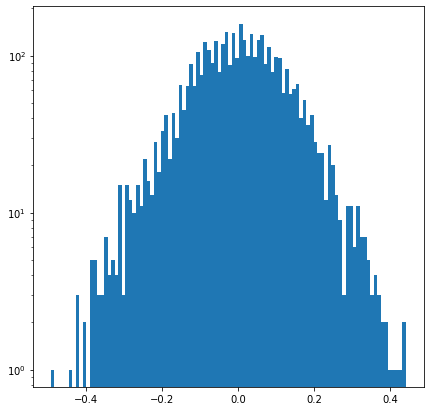

In [6]:
w = model.layers[1].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

## Check accuracy

Do not expect a good accuracy because of the low amount of neurons. I could have done better than this, but as long as it fits both Pynq-Z1 and MiniZed, it is fine with us.

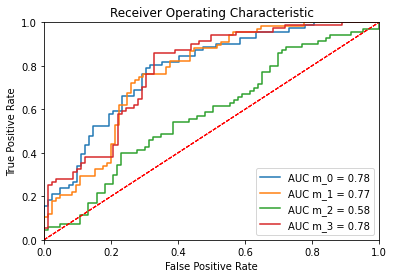

In [7]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
import plotting
import numpy

#load processed test data
X = np.load('./test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0.npy', allow_pickle=True)
y = np.load('./test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0_ground_truths.npy', allow_pickle=True)
y_keras = []
#use a quarter of the test_set to save time
for i in range(len(X)):
    quarter = int(len(X[i])/4)
    assert len(X) == len(y)
    X[i], y[i] = shuffle(X[i], y[i])
    X[i], y[i] = X[i][0:quarter],  y[i][0:quarter]

#perform inference
for index, X_data in enumerate(X):
    y_pred = [0. for ind in X_data]
    for file_idx, X_test in enumerate(X_data):
        predictions = model.predict(X_test)
        errors = np.mean(np.square(X_test-predictions), axis=1)
        y_pred[file_idx] = numpy.mean(errors)
        
    #generate auc and roc metrics
    y_test = y[index]
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    y_keras.append(y_pred)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = 'AUC m_{} = {}'.format(index, round(roc_auc,2)), linewidth = 1.5)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--', linewidth=1)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()


## Make an hls4ml configuration

Notice we're using `Strategy: Resource` for every layer, and `ReuseFactor: 64`. The Programmable Logic (FPGA part) of the Pynq-Z1 SoC is not big compared to VU9P type of parts.

We also use some settings which are good for QKeras.

Notice the `fpga_part:'xc7z020clg400-1'`.

In [8]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')
hls_config['Model'] = {}
hls_config['Model']['ReuseFactor'] = 1024
hls_config['Model']['Strategy'] = 'Resource'
hls_config['Model']['Precision'] = 'ap_fixed<32,16>'
hls_config['LayerName']['input_1']['Precision'] = 'ap_fixed<8,8>'

hls_config['LayerName']['q_dense']['Precision']['weight'] = 'ap_fixed<7,1>'
hls_config['LayerName']['q_dense']['Precision']['bias'] = 'ap_fixed<7,1>'
hls_config['LayerName']['q_dense']['accum_t'] = 'ap_fixed<32,16>'
hls_config['LayerName']['q_dense']['ReuseFactor'] = 1024

hls_config['LayerName']['batch_normalization']['Precision']['scale'] = 'ap_fixed<16,6>'
hls_config['LayerName']['batch_normalization']['Precision']['bias'] = 'ap_fixed<16,6>'
hls_config['LayerName']['batch_normalization']['ReuseFactor'] = 1024

hls_config['LayerName']['q_activation']['Precision']['result'] = 'ap_fixed<7,4>'
hls_config['LayerName']['q_activation']['ReuseFactor'] = 1024

for i in range(1,2):
    
    hls_config['LayerName']['q_dense_{}'.format(i)]['Precision']['weight'] = 'ap_fixed<7,1>'
    hls_config['LayerName']['q_dense_{}'.format(i)]['Precision']['bias'] = 'ap_fixed<7,1>'
    hls_config['LayerName']['q_dense_{}'.format(i)]['ReuseFactor'] = 1024
    hls_config['LayerName']['q_dense_{}'.format(i)]['accum_t'] = 'ap_fixed<32,16>'

    hls_config['LayerName']['batch_normalization_{}'.format(i)]['Precision']['scale'] = 'ap_fixed<16,6>'
    hls_config['LayerName']['batch_normalization_{}'.format(i)]['Precision']['bias'] = 'ap_fixed<16,6>'
    hls_config['LayerName']['batch_normalization_{}'.format(i)]['ReuseFactor'] =1024

    hls_config['LayerName']['q_activation_{}'.format(i)]['Precision']['result'] = 'ap_fixed<7,4>'
    hls_config['LayerName']['q_activation_{}'.format(i)]['ReuseFactor'] = 1024
    
# Final output
hls_config['LayerName']['q_dense_2']['Precision']['weight'] = 'ap_fixed<7,7>'
hls_config['LayerName']['q_dense_2']['Precision']['bias'] = 'ap_fixed<7,7>'
hls_config['LayerName']['q_dense_2']['accum_t'] = 'ap_fixed<32,16>'
hls_config['LayerName']['q_dense_2']['ReuseFactor'] = 1024

# Enable tracing for all of the layers
for layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][layer]['Trace'] = True

# print("-----------------------------------")
plotting.print_dict(hls_config)
# print("-----------------------------------")

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: q_dense, layer type: QDense
Layer name: batch_normalization, layer type: BatchNormalization
Layer name: q_activation, layer type: QActivation
Layer name: q_dense_1, layer type: QDense
Layer name: batch_normalization_1, layer type: BatchNormalization
Layer name: q_activation_1, layer type: QActivation
Layer name: q_dense_2, layer type: QDense
Model
  ReuseFactor:       1024
  Strategy:          Resource
  Precision:         ap_fixed<32,16>
LayerName
  input_1
    Precision:       ap_fixed<8,8>
    Trace:           True
  q_dense
    Precision
      weight:        ap_fixed<7,1>
      bias:          ap_fixed<7,1>
    ReuseFactor:     1024
    accum_t:         ap_fixed<32,16>
    Trace:           True
  batch_normalization
    Precision
      scale:         ap_fixed<16,6>
      bias:          ap_fixed<16,6>
    ReuseFactor:     1024
    Trace:           True
  q_activation
    Precision
      result:        ap_

## Convert and Compile

You can set some target specific configurations:

- Define the `interface`, which for our current setup should always be `m_axi`.
- Define the  width of the AXI bus. For the time being, use `16` that is each clock cycle you transfer a single input or output value (`ap_fixed<16,*>`).
- Define the implementation. For the time being, use `serial`.

In [9]:
interface = 'm_axi' # 's_axilite', 'm_axi', 'hls_stream'
axi_width = 8 # 16, 32, 64
implementation = 'serial' # 'serial', 'dataflow'

In [10]:
#output_dir='hls/' + '256x16x8x256_' + '_' + interface + '_' + str(axi_width) + '_' + implementation + '_prj'
output_dir='hls/' + board_name + '_' + acc_name + '_' + interface + '_' + str(axi_width) + '_' + implementation + '_prj' 

backend_config = hls4ml.converters.create_backend_config(fpga_part=fpga_part)
backend_config['ProjectName'] = acc_name
backend_config['KerasModel'] = model
backend_config['HLSConfig'] = hls_config
backend_config['OutputDir'] = output_dir
backend_config['Backend'] = 'Pynq'
backend_config['Interface'] = interface
backend_config['IOType'] = 'io_parallel'
backend_config['AxiWidth'] = str(axi_width)
backend_config['Implementation'] = implementation
backend_config['ClockPeriod'] = 10

#print("-----------------------------------")
#plotting.print_dict(backend_config)
#print("-----------------------------------")

hls_model = hls4ml.converters.keras_to_hls(backend_config)
# hls_model = hls4ml.converters.convert_from_keras_model(model,
#                                                                 hls_config=hls_config,
#                                                                 output_dir=output_dir,
#                                                                 fpga_part=fpga_part,
#                                                                 clock_period=10,
#                                                                 io_type='io_parallel',
#                                                                 project_name='anomaly_detector')

_ = hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, current shape: [[None, 256]]
Layer name: q_dense, layer type: QDense, current shape: [[None, 256]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 16]]
Layer name: q_activation, layer type: Activation, current shape: [[None, 16]]
Layer name: q_dense_1, layer type: QDense, current shape: [[None, 16]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 8]]
Layer name: q_activation_1, layer type: Activation, current shape: [[None, 8]]
Layer name: q_dense_2, layer type: QDense, current shape: [[None, 8]]
Creating HLS model
Writing HLS project
Done


## Profiling

In [11]:
%%time
%matplotlib inline

# Run tracing on a portion of the test set for the hls model (fixed-point precision) 
hls4ml_pred, hls4ml_trace = hls_model.trace(np.ascontiguousarray(X[0][0][0]))

# Run tracing on a portion of the test set for the Keras model (floating-point precision)
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X[0][0])

# Run prediction on a portion of the test set for the hls model (fixed-point precision)
#y_hls = hls_model.predict(np.ascontiguousarray(X[0][0][0]))

#_ = hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=X[0][0])

Recompiling anomaly_detector with tracing
Writing HLS project
Done
Processing input_1 in Keras model...
Processing q_dense in Keras model...
Processing batch_normalization in Keras model...
Processing q_activation in Keras model...
Processing q_dense_1 in Keras model...
Processing batch_normalization_1 in Keras model...
Processing q_activation_1 in Keras model...
Processing q_dense_2 in Keras model...
Done taking outputs for Keras model.
CPU times: user 1.78 s, sys: 69.5 ms, total: 1.85 s
Wall time: 6.63 s


Let's just print the output of the first layer, for the first sample, for both the Keras and hls4ml models.

In [12]:
print('-----------------------------------')
print("Keras layer 'q_dense', first sample:")
print(keras_trace['q_dense'][0])
print('-----------------------------------')
print("hls4ml layer 'q_dense', first sample:")
print(hls4ml_trace['q_dense'][0])
print('-----------------------------------')

-----------------------------------
Keras layer 'q_dense', first sample:
[  83.650406  -21.766193   61.8548    -47.02852   283.5316    -53.447346
  -11.572955  -52.952713  -77.83084    46.108673 -645.3818     18.077194
  -42.128624   38.289898   99.58158   -73.689865]
-----------------------------------
hls4ml layer 'q_dense', first sample:
[  83.6875    -18.578125   60.375     -47.        288.46875   -56.78125
  -12.703125  -53.453125  -76.21875    41.890625 -655.3125     21.140625
  -45.34375    36.109375  100.203125  -74.046875]
-----------------------------------


## Prediction and Comparison


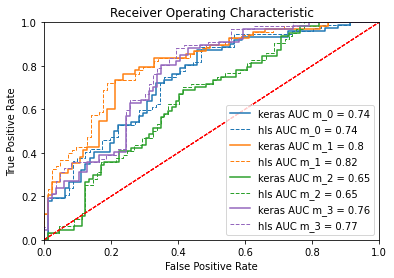

In [13]:
#load processed test data
X = np.load('./test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0.npy', allow_pickle=True)
y = np.load('./test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0_ground_truths.npy', allow_pickle=True)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

#use a quarter of the test_set to save time
for i in range(len(X)):
    quarter = int(len(X[i])/4)
    assert len(X) == len(y)
    X[i], y[i] = shuffle(X[i], y[i])
    X[i], y[i] = X[i][0:quarter],  y[i][0:quarter]

#perform inference
for index, X_data in enumerate(X):
    keras_pred = [0. for ind in X_data]
    hls_pred = [0. for ind in X_data]
    for file_idx, X_test in enumerate(X_data):
        keras_predictions = model.predict(X_test)
        keras_errors = np.mean(np.square(X_test-keras_predictions), axis=1)
        keras_pred[file_idx] = numpy.mean(keras_errors)
        
        hls_predictions = hls_model.predict(X_test)
        hls_errors = np.mean(np.square(X_test-hls_predictions), axis=1)
        hls_pred[file_idx] = numpy.mean(hls_errors)
        
    #generate auc and roc metrics
    y_test = y[index]
    k_fpr, k_tpr, k_threshold = metrics.roc_curve(y_test, keras_pred)
    k_roc_auc = metrics.auc(k_fpr, k_tpr)
    h_fpr, h_tpr, h_threshold = metrics.roc_curve(y_test, hls_pred)
    h_roc_auc = metrics.auc(h_fpr, h_tpr)


    plt.title('Receiver Operating Characteristic')
    plt.plot(k_fpr, k_tpr, label = 'keras AUC m_{} = {}'.format(index, round(k_roc_auc,2)), linewidth = 1.5, color=colors[index])
    plt.plot(h_fpr, h_tpr, label = 'hls AUC m_{} = {}'.format(index, round(h_roc_auc,2)), linewidth = 1, linestyle='--', color=colors[index])
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--', linewidth=1)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()


## Synthesis

In [14]:
hls_model.build(csim=False,synth=True,export=True, vsynth=False)

hls4ml.report.read_vivado_report(output_dir)

Found 1 solution(s) in hls/pynqz1_anomaly_detector_m_axi_8_serial_prj/anomaly_detector_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'anomaly_detector_axi'
* Date:           Thu Apr 22 18:32:18 2021

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        anomaly_detector_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |  10.00|     9.095|        1.25|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +------+------+------+------+---------+
    |   Latency   |   Interval  | Pipeline|
    |  min |  max |  min |  max |   Type  |
    +------+------+------+------+---------+
    |  2731|  2734| 

## Resource Reference

See the resources availables on different boards.

```
+-----------------+---------+-------+--------+-------+-----+                    
|                 |               Resource                 |
+-----------------+---------+-------+--------+-------+-----+
|      Board      | BRAM_18K| DSP48E|   FF   |  LUT  | URAM|
+-----------------+---------+-------+--------+-------+-----+
|   PYNQ-Z1/Z2    |      280|    220|  106400|  53200|    0|
+-----------------+---------+-------+--------+-------+-----+
|     MiniZed     |      100|     66|   28800|  14400|    0|
+-----------------+---------+-------+--------+-------+-----+
``` 

## Generate .dat Files

The .dat files are used
- during the following `csim` step
- to generate the header files for SDK

In [19]:
f = open(output_dir + '/tb_data/tb_input_features.dat', 'w')

# This is under the assumption that 
# 1. all the machines have the same number of wave files
# 2. all of the wave files have the same number of frames
# 3. all of the frames have the same length

machine_count=len(X)
wav_count=len(X[0])
frame_count=len(X[0][0])
frame_length=len(X[0][0][0])

print('Machine count: {}'.format(machine_count))
print('Wave count: {}'.format(wav_count))
print('Frame count: {}'.format(frame_count))
print('Frame length: {}'.format(frame_length))

# Save the first N wave files of the first machine
N=1
for i in (range(N)):
    for j in range(frame_count):
        for k in range(frame_length):
            f.write('{} '.format(X[0][i][j][k]))
        f.write('\n')
f.close()

f = open(output_dir + '/tb_data/tb_output_predictions.dat', 'w')
for i in range(N):
    f.write('{} '.format(y[0][i]))
    f.write('\n')
f.close()

Machine count: 4
Wave count: 153
Frame count: 197
Frame length: 256


## Run Vivado HLS csim

At this step we generate simulation traces out from the hls4ml-model.

Run the following cell to run Vivado HLS GUI:

In [20]:
!cd $output_dir && vivado_hls -p $acc_name\_prj


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'giuseppe' on host 'frodo' (Linux_x86_64 version 4.15.0-142-generic) on Thu Apr 22 19:42:07 EDT 2021
INFO: [HLS 200-10] On os Ubuntu 18.04.5 LTS
INFO: [HLS 200-10] In directory '/home/giuseppe/teaching/spring_2021/csee_e6868/hls4ml-tutorial-julesmuhizi/deploy/vivado_flow/hls/pynqz1_anomaly_detector_m_axi_8_serial_prj'
INFO: [HLS 200-10] Bringing up Vivado HLS GUI ... 
INFO: [Common 17-206] Exiting vivado_hls at Thu Apr 22 23:11:45 2021...


**IMPORTANT** Click the button to `Run C Simulation`.

This will generate simulation traces with fixed-point arythmetic.

When completed close Vivado HLS GUI.

## Integrate IP in a Vivado Project and Generate Bitstream (Step 5)

In [18]:
!cd sys/$board_name && make clean sys-gui ACC=$acc_name INTERFACE=$interface

rm -rf *.log *.txt *.jou *.str *_project NA
vivado -source tcl/script.tcl -mode gui -tclargs anomaly_detector m_axi

****** Vivado v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

Sourcing tcl script '/home/giuseppe/.Xilinx/Vivado/Vivado_init.tcl'
start_gui
INFO: [Common 17-206] Exiting Vivado at Thu Apr 22 19:41:44 2021...


**TODO** Tell the user how to visualize the `Block Diagram` to get a better understanding of the IP integration with both Zynq and MicroBlaze PS.

## Configure Software in Vivado SDK and Run HW/SW on the Board (Step 6)

Create Vivado SDK project.

- `make sdk` to configure an application with register polling
- `make sdk-irq` to configure an application with interrupts (default)

In [ ]:
!source /tools/Xilinx/Vivado/2019.1/settings64.sh && cd sdk/$board_name && make clean sdk ACC=$acc_name SAMPLE_COUNT=10

Edit the following files:
- anomaly_detector_axi.h
- anomaly_detector_axi.cpp
- anomaly_detector_test.cpp


### `anomaly_detector_axi.h`

```
#ifndef ANOMALY_DETECTOR_AXI_H_
#define ANOMALY_DETECTOR_AXI_H_

#include "anomaly_detector.h"

#if 0
static const unsigned N_IN = 256;
static const unsigned N_OUT = 256;
typedef ap_fixed<8,8> input_axi_t;
typedef ap_fixed<8,8> output_axi_t;

void anomaly_detector_axi(
    input_axi_t in[N_IN],
    output_axi_t out[N_OUT]
        );
#else
#define CEILING_DIV(x, y) (((x) + (y) - 1) / (y) )

// Model dimensions
static const unsigned N_IN = 256;
static const unsigned N_OUT = 256;

// Max batch size
static const unsigned MAX_BATCH_SIZE = 197;

// Model word size
static const unsigned W_IN = 8;
static const unsigned W_OUT = 8;

// Width of the AXI busses. It is usually 32 or 64 on Zynq.
static const unsigned AXI_WIDTH = 64;

// Word count in a single AXI-width word.
static const unsigned W_COUNT_IN = (AXI_WIDTH / W_IN);
static const unsigned W_COUNT_OUT = (AXI_WIDTH / W_OUT);

// Depth of AXI busses given the model inputs and outputs.
static const unsigned AXI_DEPTH_IN = CEILING_DIV((W_IN * N_IN), AXI_WIDTH);
static const unsigned AXI_DEPTH_OUT = CEILING_DIV((W_OUT * N_OUT), AXI_WIDTH);

typedef ap_uint<AXI_WIDTH> input_axi_t;
typedef ap_uint<AXI_WIDTH> output_axi_t;

void anomaly_detector_axi(
		input_axi_t in[AXI_DEPTH_IN * MAX_BATCH_SIZE],
		output_axi_t out[AXI_DEPTH_OUT * MAX_BATCH_SIZE],
		unsigned batch
);

#endif
#endif
```

### `anomaly_detector_axi.cpp`

```
#include "anomaly_detector_axi.h"

typedef layer10_t result_t;

#if 0
void anomaly_detector_axi(
        input_axi_t in[N_IN],
        output_axi_t out[N_OUT]
        ){

#pragma HLS INTERFACE s_axilite port=return bundle=CTRL_BUS
#pragma HLS INTERFACE m_axi depth=N_IN port=in offset=slave bundle=IN_BUS
#pragma HLS INTERFACE m_axi depth=N_OUT port=out offset=slave bundle=OUT_BUS

    unsigned short in_size = 0;
    unsigned short out_size = 0;

    input_t in_local[N_IN];
    result_t out_local[N_OUT];

    for(unsigned i = 0; i < N_IN; i++){
#pragma HLS UNROLL
        in_local[i] = in[i]; // Read input with cast
    }

    anomaly_detector(in_local, out_local, in_size, out_size);

    for(unsigned i = 0; i < N_OUT; i++){
#pragma HLS UNROLL
        out[i] = out_local[i]; // Write output with cast
    }
}
#else

void load_axi(input_axi_t axi_in_local[AXI_DEPTH_IN], input_axi_t in[AXI_DEPTH_IN * 197], unsigned b) {
#pragma HLS INLINE off
	LOAD:
            for (unsigned i = 0; i < AXI_DEPTH_IN; i++) {
#pragma HLS PIPELINE
                axi_in_local[i] = in[b * AXI_DEPTH_IN + i];
            }
}

void load_unpack(input_t model_in[N_IN], input_axi_t axi_in_local[AXI_DEPTH_IN], unsigned b) {
        {
#pragma HLS INLINE off

        	LOAD_UNPACK_OUTER:
            for (unsigned i = 0; i < AXI_DEPTH_IN; i++) {
#pragma HLS UNROLL
                input_axi_t axi_data = axi_in_local[b * AXI_DEPTH_IN + i];
                LOAD_UNPACK_INNER:
                for (unsigned j = 0; j < W_COUNT_IN; j++) {
#pragma HLS UNROLL
                    input_t data;
                    data.range(W_IN-1, 0) = axi_data.range(((j+1)*W_IN)-1, j*W_IN);
                    model_in[i * W_COUNT_IN + j].range(W_IN- 1, 0) = data.range(W_IN-1, 0);
                }
            }
        }
}

void load(input_t model_in[N_IN], input_axi_t in[AXI_DEPTH_IN * 197], unsigned b) {
#pragma HLS INLINE off
    // Local copy of the packed data from the AXI ports
    input_axi_t axi_in_local[AXI_DEPTH_IN];
 //#pragma HLS STREAM variable=axi_in_local dim=1
#pragma HLS ARRAY_PARTITION variable=axi_in_local complete dim=1

    load_axi(axi_in_local, in, b);

    load_unpack(model_in, axi_in_local, b);
}


void store_pack(output_axi_t axi_out_local[AXI_DEPTH_OUT], result_t model_out[N_OUT], unsigned b) {
	#pragma HLS INLINE off

	STORE_PACK_OUTER:
	            for (unsigned i = 0; i < AXI_DEPTH_OUT; i++) {
	#pragma HLS UNROLL
	                output_axi_t axi_data;
	                STORE_PACK_INNER:
	                for (unsigned j = 0; j < W_COUNT_OUT; j++) {
	#pragma HLS UNROLL
	                    ap_fixed<8,8> data = model_out[i * W_COUNT_OUT + j]; // cast
	                    axi_data.range(((j+1)*W_OUT)-1, j*W_OUT) = data.range(W_OUT-1, 0);
	                }
	                axi_out_local[i] = axi_data;
	            }
}

void store_axi(output_axi_t out[AXI_DEPTH_OUT * 197], output_axi_t axi_out_local[AXI_DEPTH_OUT],  unsigned b) {
	#pragma HLS INLINE off
	STORE:
	            for (unsigned i = 0; i < AXI_DEPTH_OUT; i++) {
	#pragma HLS PIPELINE
	                out[b * AXI_DEPTH_OUT + i] = axi_out_local[i];
	            }
}

void store(output_axi_t out[AXI_DEPTH_OUT * 197], result_t model_out[N_OUT], unsigned b) {
#pragma HLS INLINE off


    output_axi_t axi_out_local[AXI_DEPTH_OUT];
#pragma HLS ARRAY_PARTITION variable=axi_out_local complete dim=1
//#pragma HLS STREAM variable=axi_out_local dim=1

    store_pack(axi_out_local,  model_out, b);

    store_axi(out, axi_out_local, b);
}

void anomaly_detector_axi(
        input_axi_t in[AXI_DEPTH_IN * 197],
        output_axi_t out[AXI_DEPTH_OUT * 197],
		unsigned batch
        ){
    const unsigned axi_in_size = AXI_DEPTH_IN * 197;
    const unsigned axi_out_size = AXI_DEPTH_OUT * 197;

#pragma HLS INTERFACE s_axilite port=return bundle=CTRL_BUS
#pragma HLS INTERFACE m_axi depth=axi_in_size port=in offset=slave bundle=IN_BUS
#pragma HLS INTERFACE m_axi depth=axi_out_size port=out offset=slave bundle=OUT_BUS
#pragma HLS INTERFACE s_axilite port=batch bundle=CTRL_BUS

    unsigned short in_size = 0;
    unsigned short out_size = 0;



    // Model input and output data
    input_t model_in[N_IN];
    result_t model_out[N_OUT];

BATCH:
    for (unsigned b = 0; b < MAX_BATCH_SIZE; b++) {
//#pragma HLS PIPELINE // issue: unroll everything in the hierarchy
//#pragma HLS DATAFLOW // issue: race conditions
    	if (b >= batch) break;

#if 0
LOAD:
        {
#pragma HLS INLINE off
            for (unsigned i = 0; i < AXI_DEPTH_IN; i++) {
#pragma HLS UNROLL
                input_axi_t axi_data = in[b * N_IN + i];
                for (unsigned j = 0; j < W_COUNT_IN; j++) {
#pragma HLS UNROLL
                    input_t data;
                    data.range(W_IN-1, 0) = axi_data.range(((j+1)*W_IN)-1, j*W_IN);
                    model_in[i * W_COUNT_IN + j].range(W_IN- 1, 0) = data.range(W_IN-1, 0);
                }
            }
        }
#else

        load(model_in, in, b);

#endif

        anomaly_detector(model_in, model_out, in_size, out_size);

#if 0
STORE:
        {
#pragma HLS INLINE off
            for (unsigned i = 0; i < AXI_DEPTH_OUT; i++) {
#pragma HLS UNROLL
                output_axi_t axi_data;
                for (unsigned j = 0; j < W_COUNT_OUT; j++) {
#pragma HLS UNROLL
                    result_t data = model_out[i * W_COUNT_OUT + j];
                    axi_data.range(((j+1)*W_OUT)-1, j*W_OUT) = data.range(W_OUT-1, 0);
                }
                out[b * N_OUT + i] = axi_data;
            }
        }
#else

       store(out, model_out, b);

#endif
    }

}
#endif
```

### `anomaly_detector_test.cpp`

```
#include <fstream>
#include <iostream>
#include <algorithm>
#include <vector>
#include <map>
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#include "firmware/anomaly_detector_axi.h"
#include "firmware/nnet_utils/nnet_helpers.h"

#define CHECKPOINT 1

namespace nnet {
    bool trace_enabled = true;
    std::map<std::string, void *> *trace_outputs = NULL;
    size_t trace_type_size = sizeof(double);
}

#if 0
int main(int argc, char **argv)
{
    //load input data from text file
    std::ifstream fin("tb_data/tb_input_features.dat");
    //load predictions from text file
    //  std::ifstream fpr("tb_data/tb_output_predictions.dat");

#ifdef RTL_SIM
    std::string RESULTS_LOG = "tb_data/rtl_cosim_results.log";
#else
    std::string RESULTS_LOG = "tb_data/csim_results.log";
#endif
    std::ofstream fout(RESULTS_LOG);

    std::string iline;
    //std::string pline;
    int e = 0;

    if (fin.is_open() /*&& fpr.is_open()*/) {
        while ( std::getline(fin,iline) /* && std::getline (fpr,pline) */) {
            if (e % CHECKPOINT == 0) std::cout << "Processing input " << e << std::endl;
            char* cstr=const_cast<char*>(iline.c_str());
            char* current;
            std::vector<float> in;
            current=strtok(cstr," ");
            while(current!=NULL) {
                in.push_back(atof(current));
                current=strtok(NULL," ");
            }
            /*
               cstr=const_cast<char*>(pline.c_str());
               std::vector<float> pr;
               current=strtok(cstr," ");
               while(current!=NULL) {
               pr.push_back(atof(current));
               current=strtok(NULL," ");
               }
               */

            //hls-fpga-machine-learning insert data
            input_t input_1[N_INPUT_1_1];
            nnet::copy_data<float, input_t, 0, N_INPUT_1_1>(in, input_1);
            layer10_t layer10_out[N_LAYER_10];

            //hls-fpga-machine-learning insert top-level-function
            unsigned short size_in1,size_out1;
            anomaly_detector(input_1,layer10_out,size_in1,size_out1);

            if (e % CHECKPOINT == 0) {
                /*
                   std::cout << "Predictions" << std::endl;
                //hls-fpga-machine-learning insert predictions
                for(int i = 0; i < N_LAYER_10; i++) {
                std::cout << pr[i] << " ";
                }
                std::cout << std::endl;
                */
                std::cout << "Quantized predictions" << std::endl;
                //hls-fpga-machine-learning insert quantized
                nnet::print_result<layer10_t, N_LAYER_10>(layer10_out, std::cout, true);
            }
            e++;

            //hls-fpga-machine-learning insert tb-output
            nnet::print_result<layer10_t, N_LAYER_10>(layer10_out, fout);

        }
        fin.close();
        /*fpr.close();*/
    } else {
        std::cout << "INFO: Unable to open input/predictions file, using default input." << std::endl;
        //hls-fpga-machine-learning insert zero
        input_t input_1[N_INPUT_1_1];
        nnet::fill_zero<input_t, N_INPUT_1_1>(input_1);
        layer10_t layer10_out[N_LAYER_10];

        //hls-fpga-machine-learning insert top-level-function
        unsigned short size_in1,size_out1;
        anomaly_detector(input_1,layer10_out,size_in1,size_out1);

        //hls-fpga-machine-learning insert output
        nnet::print_result<layer10_t, N_LAYER_10>(layer10_out, std::cout, true);

        //hls-fpga-machine-learning insert tb-output
        nnet::print_result<layer10_t, N_LAYER_10>(layer10_out, fout);
    }

    fout.close();
    std::cout << "INFO: Saved inference results to file: " << RESULTS_LOG << std::endl;

    return 0;
}
#else
int main(int argc, char **argv)
{
    //load input data from text file
    std::ifstream fin("tb_data/tb_input_features.dat");

#ifdef RTL_SIM
    std::string RESULTS_LOG = "tb_data/rtl_cosim_results.log";
#else
    std::string RESULTS_LOG = "tb_data/csim_results.log";
#endif
    std::ofstream fout(RESULTS_LOG);
    std::string iline;

    input_axi_t inputs[AXI_DEPTH_IN * MAX_BATCH_SIZE] ;
    output_axi_t outputs[AXI_DEPTH_OUT * MAX_BATCH_SIZE];

    unsigned batch = 2;

    if (fin.is_open()) {
        unsigned i = 0;

        std::cout << "Loading input from file ..." << std::endl;
        while ( std::getline(fin,iline) ) {
        	if (i >= batch) break;
            char* cstr=const_cast<char*>(iline.c_str());
            char* current;
            std::vector<float> in;
            current=strtok(cstr," ");
            while(current!=NULL) {
                in.push_back(atof(current));
                current=strtok(NULL," ");
            }

            //hls-fpga-machine-learning insert data
            input_t input_feature[N_IN];
            nnet::copy_data<float, input_t, 0, N_IN>(in, input_feature);

            for (unsigned j = 0; j < AXI_DEPTH_IN; j++) {
            	for (unsigned k = 0; k < W_COUNT_IN; k++) {
            		input_t data = input_feature[j * W_COUNT_IN + k];
            		inputs[i * AXI_DEPTH_IN +  j].range(((k+1)*W_IN)-1, k*W_IN) = data.range(W_IN-1, 0);
            	}
            }
            i++;
        }

        std::cout << "Total inputs: " << i << std::endl;

       anomaly_detector_axi(inputs,outputs, batch);

       for (unsigned i = 0; i < MAX_BATCH_SIZE; i++) {
    	   if (i >= batch) break;
    	   ap_fixed<8,8> output_feature[N_OUT];
    	   for (unsigned j = 0; j < AXI_DEPTH_OUT; j++) {
    		   output_axi_t output_axi = outputs[i * AXI_DEPTH_OUT +  j];
    		   for (unsigned k = 0; k < W_COUNT_OUT; k++) {
    			   output_feature[j * W_COUNT_IN + k].range(W_OUT-1, 0) = output_axi.range(((k+1)*W_OUT)-1, k*W_OUT);
    		   }
    	   }
    	   nnet::print_result<ap_fixed<8,8>, N_OUT>(output_feature, fout);
    	   nnet::print_result<ap_fixed<8,8>, N_OUT>(output_feature, std::cout, true);
       }

#if 0
            //hls-fpga-machine-learning insert top-level-function
            unsigned short size_in1,size_out1;


            if (e % CHECKPOINT == 0) {
                std::cout << "Quantized predictions" << std::endl;
                //hls-fpga-machine-learning insert quantized
                nnet::print_result<layer10_t, N_LAYER_10>(layer10_out, std::cout, true);
            }
            e++;

            //hls-fpga-machine-learning insert tb-output
            nnet::print_result<layer10_t, N_LAYER_10>(layer10_out, fout);
#endif

        fin.close();
        /*fpr.close();*/
    }

    fout.close();
    std::cout << "INFO: Saved inference results to file: " << RESULTS_LOG << std::endl;

    return 0;
}
#endif
```

In [ ]:
!xterm -e "sleep 1 && source /tools/Xilinx/Vivado/2019.1/settings64.sh && cd sdk/$board_name && make gui && sleep infinity"


You can open a serial console, for example
```
sudo minicom -D /dev/ttyUSB0
```
and see something like

![serial-console](doc/serial_console.png)